In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import cv2 
from glob import glob

In [2]:
PATH = "../input/mlub-mongolian-car-plate-prediction"

In [3]:
train_csv = pd.read_csv(os.path.join(PATH, "training.csv"))
train_csv.head()

,file_name,plate_number
0,0001.png,3803УБЧ
1,0002.png,5791УБВ
2,0003.png,1760УНЭ
3,0004.png,1407УНУ
4,0005.png,1861УНЛ


In [4]:
train_csv.describe()

,file_name,plate_number
count,3697,3697
unique,3697,3143
top,0603.png,6671УНЗ
freq,1,9


In [5]:
test_csv = pd.read_csv(os.path.join(PATH, "submission.csv"))
test_csv

,file_name,plate_number
0,3698.png,1111AAA
1,3699.png,1111AAA
2,3700.png,1111AAA
3,3701.png,1111AAA
4,3702.png,1111AAA
...,...,...
3692,7390.png,1111AAA
3693,7391.png,1111AAA
3694,7392.png,1111AAA
3695,7393.png,1111AAA


In [6]:
test_csv.describe()

,file_name,plate_number
count,3697,3697
unique,3697,1
top,7016.png,1111AAA
freq,1,3697


In [7]:
columns = train_csv.columns

for i in columns:
    print(i, train_csv[i].isnull().sum())

file_name 0
plate_number 0


In [8]:
def plot_img(img):
    plt.figure(figsize=(7,10))
    plt.imshow(img)
    plt.show()

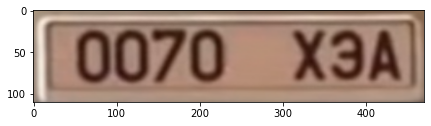

In [9]:
img = cv2.imread(os.path.join(PATH, "test/test/7390.png"))
plot_img(img)

In [10]:
training_paths = sorted(glob(os.path.join(PATH, "training/training/*")))
len(training_paths)

3697

In [11]:
def sort_contours(ctrs, img_gray):
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1] * 8)
    return sorted_ctrs

In [12]:
def check(plates):
    h1 = plates[0].shape[0]
    checks = True
    for i in range(len(plates)):
        thr = h1 / plates[i].shape[0]
        if thr < 0.8 or thr > 1.3:
            checks = False
    return checks

In [13]:
def prepare_img(path):
    img = cv2.imread(path)
    thresholds = [50 + i*10 for i in range(19)]
    for thresh in thresholds:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray[img_gray < thresh] = 0
        img_gray[img_gray > thresh] = 255
        
        contours, _ = cv2.findContours(img_gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        crop_characters = []
        for c in sort_contours(contours, img_gray):
            (x, y, w, h) = cv2.boundingRect(c)
            
            if h / img_gray.shape[0] >= 0.25 and h / img_gray.shape[0] <= 0.7 and w / img_gray.shape[1] > 0.03 and \
            w / img_gray.shape[1] < 0.2:  
                
                curr_num = img_gray[y:y+h, x:x+w]
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                
                if curr_num[0][0] == 255:
                    crop_characters.append(curr_num)
                    
        if len(crop_characters) == 7 and check(crop_characters):
            return crop_characters

In [14]:
character_img = []
characters = []
for i, path in enumerate(tqdm(training_paths)):
    cropped_img = prepare_img(path)
    if cropped_img and len(train_csv.loc[i, "plate_number"]) == 7:
        for img in cropped_img:
            resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
            resized = resized / 255
            character_img.append(resized)
        for char in train_csv.loc[i, "plate_number"]:
            characters.append(char)

100%|██████████| 3697/3697 [00:32<00:00, 113.95it/s]


In [15]:
print(f"Number of images: {len(character_img)}")
print(f"Number of characters: {len(characters)}")

Number of images: 14329
Number of characters: 14329


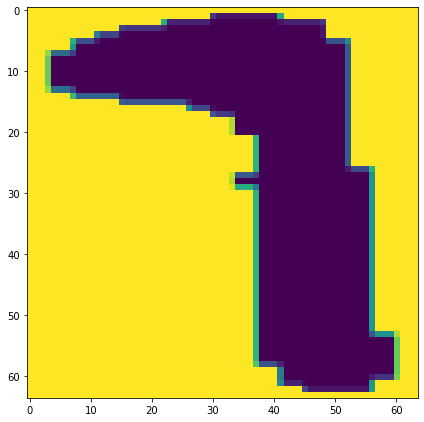

In [16]:
sample = character_img[10]
plot_img(sample)

In [17]:
characters[10]

'1'

In [18]:
character_img = np.array(character_img).reshape(-1, 64, 64, 1)
characters = np.array(characters)
le = LabelEncoder()
encoded = le.fit_transform(characters)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(character_img, encoded, test_size=0.2)

In [20]:
gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                   zoom_range = 0.1,
                                                   width_shift_range=0.1,
                                                   height_shift_range=0.1)

In [21]:
gen.fit(X_train)

In [22]:
unique_char = len(np.unique(characters))
unique_char

35

In [23]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, kernel_size = 3, activation="relu", input_shape = (64, 64, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, kernel_size = 3, strides=2, padding='valid', activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(128, kernel_size = 3, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, kernel_size = 3, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, kernel_size = 3, strides=2, padding='same', activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(256, kernel_size = 3, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(256, kernel_size = 3, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(unique_char, activation='softmax'))

In [24]:
def lr_schedule(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [25]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
check_point = keras.callbacks.ModelCheckpoint("tf.h5", save_best_only=True)

In [26]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [27]:
history = model.fit_generator(gen.flow(X_train,y_train), 
                              verbose=1,
                              validation_data=(X_val, y_val), 
                              epochs=30,
                              callbacks=[lr_scheduler, check_point])

Epoch 1/30
359/359 [==============================] - 12s 34ms/step - loss: 34.5321 - accuracy: 0.6832 - val_loss: 2.0285 - val_accuracy: 0.5516
Epoch 2/30
359/359 [==============================] - 12s 35ms/step - loss: 0.7654 - accuracy: 0.8330 - val_loss: 0.6389 - val_accuracy: 0.8234
Epoch 3/30
359/359 [==============================] - 12s 33ms/step - loss: 0.6490 - accuracy: 0.8625 - val_loss: 0.3594 - val_accuracy: 0.9313
Epoch 4/30
359/359 [==============================] - 11s 31ms/step - loss: 0.5562 - accuracy: 0.8768 - val_loss: 0.3745 - val_accuracy: 0.9211
Epoch 5/30
359/359 [==============================] - 13s 37ms/step - loss: 0.4881 - accuracy: 0.8852 - val_loss: 0.4284 - val_accuracy: 0.9103
Epoch 6/30
359/359 [==============================] - 11s 32ms/step - loss: 0.4711 - accuracy: 0.8942 - val_loss: 0.6706 - val_accuracy: 0.8165
Epoch 7/30
359/359 [==============================] - 11s 31ms/step - loss: 0.4234 - accuracy: 0.9098 - val_loss: 0.8063 - val_accuracy

In [28]:
def check_test(plates):
    h1 = plates[0].shape[0]
    checks = True
    for i in range(len(plates)):
        thr = h1 / plates[i].shape[0]
        if thr < 0.65 or thr > 1.5:
            checks = False
    return checks

In [29]:
def prepare_test1(path):
    img = cv2.imread(path)
    thresholds = [50 + i*10 for i in range(19)]
    for thresh in thresholds:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray[img_gray < thresh] = 0
        img_gray[img_gray > thresh] = 255
        
        contours, _ = cv2.findContours(img_gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        crop_characters = []
        for c in sort_contours(contours, img_gray):
            (x, y, w, h) = cv2.boundingRect(c)
            
            if h/img_gray.shape[0]>=0.25 and h/img_gray.shape[0]<=0.7 and w/img_gray.shape[1]>0.03 and \
            w/img_gray.shape[1]<0.2: 
                
                curr_num = img_gray[y:y+h,x:x+w]
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                
                if curr_num[0][0] == 255:
                    crop_characters.append(curr_num)
                    
        if len(crop_characters) == 7 and check_test(crop_characters):
            return crop_characters

In [30]:
def crop_char(img_gray, thresh):    
    img_gray[img_gray < thresh] = 0
    img_gray[img_gray > thresh] = 255
    
    contours, _ = cv2.findContours(img_gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    crop_characters = []
    
    for c in sort_contours(contours, img_gray):
        (x, y, w, h) = cv2.boundingRect(c)
        
        if h/img_gray.shape[0]>=0.2 and h/img_gray.shape[0]<=0.8 and w/img_gray.shape[1]>0.03: 
            curr_num = img_gray[y:y+h,x:x+w]
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            if curr_num[0][0] == 255:
                crop_characters.append(curr_num)
                
    return crop_characters

In [31]:
def prepare_test2(path):
    img = cv2.imread(path)
    thresholds = [20 + i*10 for i in range(22)]
    best_thresh = 100
    best_score = 7
    length = 0
    
    for thresh in thresholds:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        crop_characters = crop_char(img_gray, thresh)
        
        if abs(7 - len(crop_characters)) < best_score:
            best_thresh = thresh
            length = len(crop_characters)
            best_score = abs(7 - length)
            
        elif abs(7 - len(crop_characters)) == best_score and len(crop_characters) >= length:
            best_thresh = thresh
            length = len(crop_characters)
            best_score = abs(7 - length)
            
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return crop_char(img_gray, best_thresh)

In [32]:
test_paths = sorted(glob(os.path.join(PATH, "test/test/*")))
len(test_paths)

3697

In [33]:
predictions = []
for path in tqdm(test_paths):
    if prepare_img(path):
        cropped_img = prepare_img(path)
        
    elif prepare_test1(path):
        cropped_img = prepare_test1(path)
        
    else:
        cropped_img = prepare_test2(path)
        
    if cropped_img:
        characters = []
        
        for i in range(len(cropped_img)):
            resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
            resized = resized / 255
            reshaped = resized.reshape(-1, 64, 64, 1)
            predict = model.predict_classes(reshaped)
            predict = le.inverse_transform(predict)
            
            if i < 4:
                if predict[0] == 'О':
                    characters.append('0')
                elif predict[0] == 'З' or predict[0] == 'Э':
                    characters.append('3')
                elif predict[0] == 'Т':
                    characters.append('1')
                else:
                    characters.append(predict[0])
                    
            else:
                if predict[0] == '0':
                    characters.append('О')
                elif predict[0] == '3':
                    characters.append('З')
                else:
                    characters.append(predict[0])
                    
        predictions.append("".join(characters))
    else:
        predictions.append("")

100%|██████████| 3697/3697 [19:47<00:00,  3.11it/s]


In [34]:
test_csv["plate_number"] = predictions
test_csv.to_csv("submission.csv", index=False)